## Feature Selection by Random Shuffling

We can implement feature selection by feature shuffling with Feature-engine.

The selector takes any machine learning algorithm as input, and any metric from those allowed by Scikit-learn.

In [1]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from feature_engine.selection import SelectByShuffling

from helper_fe_v2 import (
            get_full_datapath_nm,
            read_df_from_file,
            check_module_members,
            gen_correlation,
            do_bkwd_fwd_selection,
            yaml_path,
            read_yaml_conf,
            remove_duplicates, 
            drop_const_features,
            drop_quasi_const_features ,
            remove_const_quasi_const, 
            run_randomForestClassifier,
            run_logistic,
            run_randomForestRegressor
)

In [2]:
config = read_yaml_conf(yaml_path())

data = read_df_from_file ( config['files']['test_data_set2'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\fselect_dataset_2.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\fselect_dataset_2.csv


(50000, 109)

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [4]:
# We will use Random Forests, but remember that 
# you can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

In [5]:
sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=50,
                                                   n_jobs=4,
                                                   random_state=2909),
                  random_state=1, threshold=0)

In [6]:
# performance of model trained with all features

sel.initial_model_performance_

0.6854579498672484

In [7]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'var_1': 0.0,
 'var_2': -0.0002024604369629257,
 'var_3': 0.0,
 'var_4': 0.0,
 'var_5': 1.6933495959547962e-05,
 'var_6': -8.201881740943495e-05,
 'var_7': 0.00010760028479472883,
 'var_8': 0.0,
 'var_9': 0.0,
 'var_10': 5.258686384601585e-05,
 'var_11': -3.277729722928058e-05,
 'var_12': 0.0,
 'var_13': -0.00010196943289919602,
 'var_14': -2.3110891274491507e-05,
 'var_15': 0.0,
 'var_16': 0.013737763046104967,
 'var_17': -0.00016576283448843654,
 'var_18': 0.0,
 'var_19': -0.00012150727096804648,
 'var_20': 0.0,
 'var_21': 0.0002472741766194053,
 'var_22': -5.8923334229632474e-05,
 'var_23': 0.0,
 'var_24': -4.422123148661861e-06,
 'var_25': 0.0,
 'var_26': -2.6175085022561717e-05,
 'var_27': 0.0,
 'var_28': 0.0,
 'var_29': 2.673503994976567e-05,
 'var_30': -0.001490248247070114,
 'var_31': -7.53158234848561e-05,
 'var_32': 3.770014702653146e-05,
 'var_33': 0.0,
 'var_34': 0.0004493963207606866,
 'var_35': 0.0,
 'var_36': 0.0,
 'var_37': -4.3715888632611666e-05,
 'var_38': 0.0001642

<AxesSubplot:>

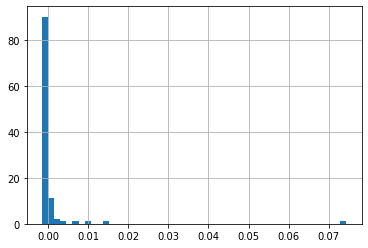

In [8]:
# histogram of the performance drops

pd.Series(sel.performance_drifts_).hist(bins=50)

<AxesSubplot:>

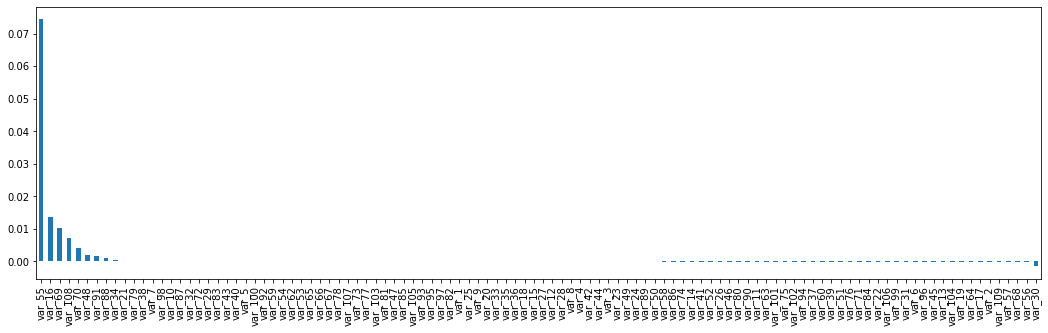

In [9]:
# bar plot of the performance drops

pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [10]:
# features that will be removed

len(sel.features_to_drop_)

101

In [11]:
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 7), (15000, 7))

In [12]:
# Now let's build a random forests only with the selected features

rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))

train auc score:  0.7010001123593995
test auc score:  0.6953477325844082


As you can see, the random forests with the selected features show a similar performance (or even slightly higher) to the random forests built using all of the features. And it provides a simpler, faster and more reliable model.

## Regression

In [13]:
config = read_yaml_conf(yaml_path())
data = read_df_from_file ( config['files']['housing_data'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\housing_prices_train.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\input_data\housing_prices_train.csv


(1460, 81)

In [14]:
# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [15]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [16]:
# fill missing values

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [17]:
# In this case, I will build Random Forests, but remember that
# you can use this procedure for any machine learning algorithm

# I build few and shallow trees to avoid overfitting
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=3,
                           random_state=2909,
                           n_jobs=4)


In [18]:
sel = SelectByShuffling(
    variables=None, # automatically examines all numerical variables
    estimator=rf, # the estimator
    scoring='neg_root_mean_squared_error', # the performance metric
    threshold=None, # threshold will be mean value of metric accross features
    cv=3,#  cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestRegressor(max_depth=3, n_jobs=4,
                                                  random_state=2909),
                  random_state=1, scoring='neg_root_mean_squared_error')

In [19]:
# performance of model trained using all features

sel.initial_model_performance_

-37824.88457786946

<AxesSubplot:>

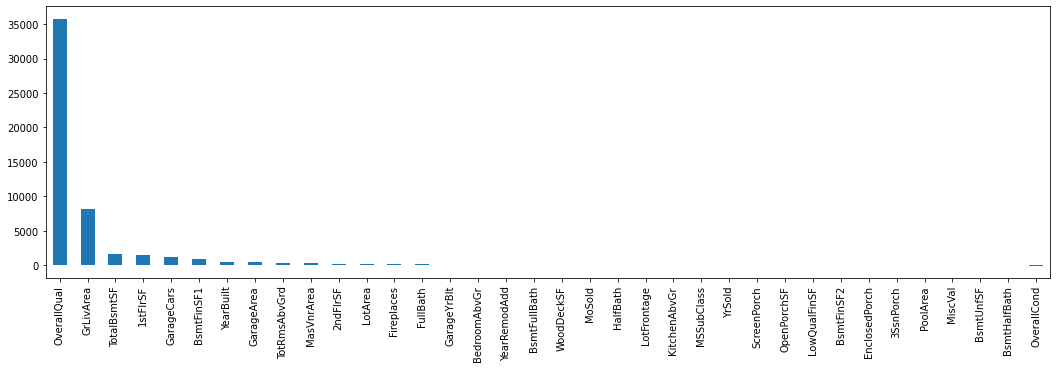

In [20]:
# performance drifts

pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [21]:
sel.features_to_drop_

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [22]:
# select the features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1022, 4), (438, 4))

In [23]:
# check model performance using only selected features
rf.fit(X_train, y_train)

# print performance metrics
print('train rmse: ', mean_squared_error(y_train, rf.predict(X_train), squared=False))
print('train r2: ', r2_score(y_train, (rf.predict(X_train))))
print()
print('test rmse: ', mean_squared_error(y_test, rf.predict(X_test), squared=False))
print('test r2: ', r2_score(y_test, rf.predict(X_test)))

train rmse:  35958.5144285725
train r2:  0.7880218953729026

test rmse:  40006.14519421906
test r2:  0.7642519264873466
